# Implementing a Neural Network for CIFAR dataset
In this exercise, you should change H.W_1 to work on the CIFAR dataset.

CIFAR is a dataset that consists of 60,000 32x32 colour images in 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), with 6000 images per class.

We will have the same components as were in the previous exercise:
- Loading the data and visualize some of the images
- Training the model. Instead of loading a pre-trained model, we will define a new very basic architecture.


## 1) Loading CIFAR dataset

You should load the CIFAR dataset. You can use [the pytorch CIFAR tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). As was done in the previous exercise, you should define a dictionary of ``dataloaders``. For now, no need to define pre-process to the data. 
Please stick to the API of H.W_1, create a dataloaders disctionary ``{'train','val'}``

You can use batch_size = 128

In [ ]:
%matplotlib inline
import warnings
import numpy as np
import matplotlib.pyplot as plt
import time
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms

warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=4)

valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
valloader = torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=4)

dataloaders = {
    "train": trainloader,
    "val": valloader
}

dataset_sizes = {
    "train": trainset.data.shape[0],
    "val": valset.data.shape[0]
}

class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**If you manage to load the CIFAR data correctly, you should run the next three cells and see some of the images.**

## Visualize some of the training images

In this dataset the size of the images are 32x32. 

It is important to visualize the data in order to see that we load them correctly (maybe we need to divide by 255? should we make channel permutations?) 

The code below was taken from H.W_1

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:16]
classes = classes[0:16]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

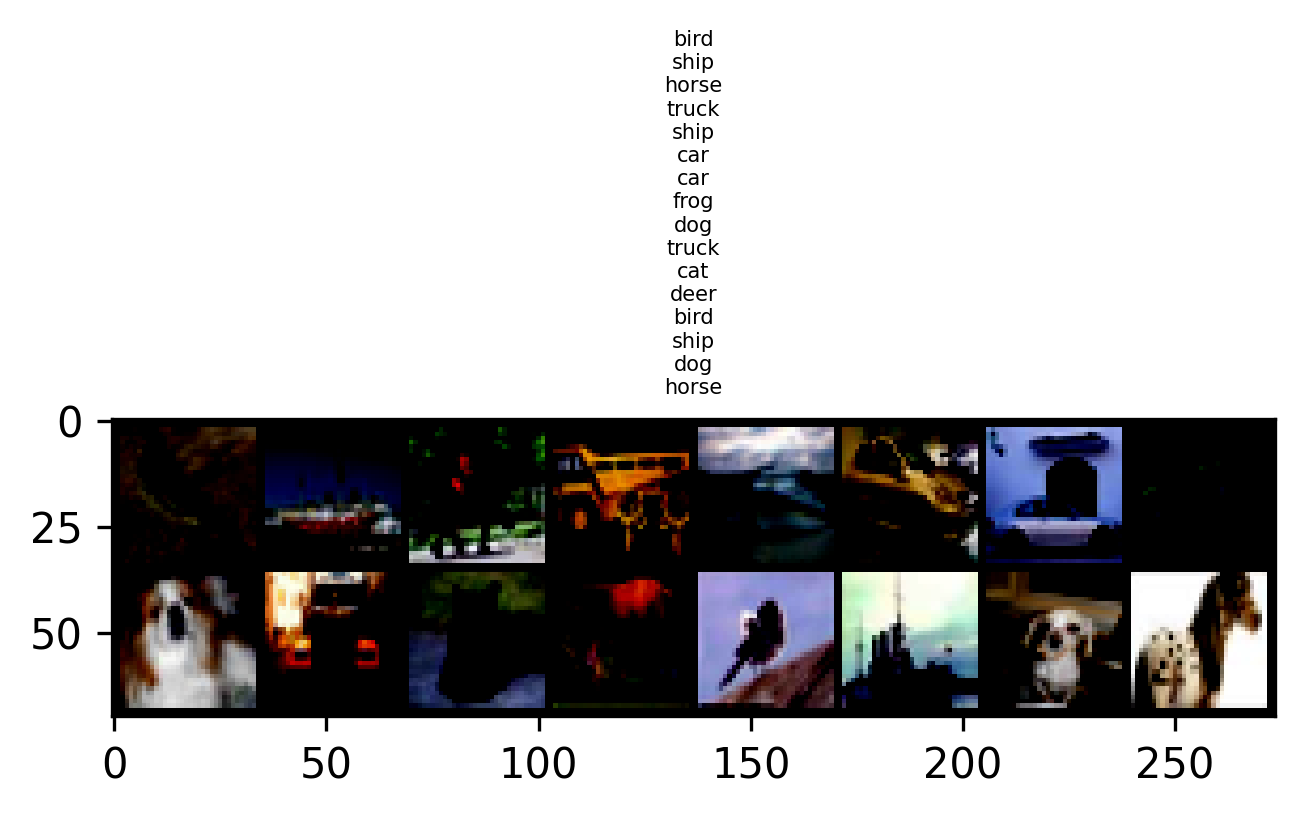

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title='\n'.join([class_names[x] for x in classes]))

## A 2-layer Neural Network

We will define 2-fully-connected-layer network using Sequential module. We have two hidden layers: the first one has 100 neurons and the second one has 20 neurons. The last layer is the output that has 10 elements.

Please pay attention that we take images after flattening (line 15 below).

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)


**Pay attention, in case you change something in the parameters, the data, data loaders, image transform, optimizations and more...you should load the model again so it will start from random weights and not from the last training**.

**You should run again the line** ``model = NeuralNetwork().to(device)``


The next two cells (defining the loss and the training loop) were copied from last exercise. 


In [ ]:
# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    training_results = {p: [] for p in ['train', 'val']}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            training_results[phase].append({'epoch': epoch, 'epoch_loss': epoch_loss, 'epoch_acc': epoch_acc})

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, training_results

In [ ]:
model, _ = train_model(model, 
                    dataloaders,
                    criterion, 
                    optimizer_ft, 
                    exp_lr_scheduler,
                    num_epochs=num_epochs)


Epoch 0/9
----------
train Loss: 2.1793 Acc: 0.2081
val Loss: 2.0443 Acc: 0.2828

Epoch 1/9
----------
train Loss: 1.9628 Acc: 0.3012
val Loss: 1.8861 Acc: 0.3351

Epoch 2/9
----------
train Loss: 1.8476 Acc: 0.3428
val Loss: 1.8014 Acc: 0.3637

Epoch 3/9
----------
train Loss: 1.7730 Acc: 0.3718
val Loss: 1.7355 Acc: 0.3848

Epoch 4/9
----------
train Loss: 1.7115 Acc: 0.3926
val Loss: 1.6795 Acc: 0.4067

Epoch 5/9
----------
train Loss: 1.6627 Acc: 0.4109
val Loss: 1.6380 Acc: 0.4212

Epoch 6/9
----------
train Loss: 1.6243 Acc: 0.4247
val Loss: 1.6075 Acc: 0.4314

Epoch 7/9
----------
train Loss: 1.5992 Acc: 0.4345
val Loss: 1.6014 Acc: 0.4318

Epoch 8/9
----------
train Loss: 1.5954 Acc: 0.4361
val Loss: 1.5986 Acc: 0.4330

Epoch 9/9
----------
train Loss: 1.5920 Acc: 0.4379
val Loss: 1.5955 Acc: 0.4354

Training complete in 1m 46s
Best val Acc: 0.435400


You can continue after you see your model learns something (the training loss is decreasing).

# 2) Losses in Pytorch

Now that you managed to run the training loop, let's understand the loss definition. PyTorch provides losses such as cross-entropy loss (`nn.CrossEntropyLoss`) that has just been used. You'll usually see the loss assigned to `criterion`. For classification problems such as CIFAR, we use the softmax function to predict class probabilities. With a softmax output, we need to use cross-entropy as the loss. To actually calculate the loss, we first define the criterion, then pass in it the output of your network and the correct labels.

*Important note!* Look at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/nn.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

It means that we need to pass in `nn.CrossEntropyLoss` the raw output of our network into, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities, which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually better to avoid doing calculations with probabilities, and generally we use log-probabilities.

**Exercise:** Change the network above to output the log-softmax and calculate the loss using the negative log-likelihood loss. Note that for `nn.LogSoftmax` and `F.log_softmax` you'll need to set the `dim` keyword argument appropriately. `dim=0` calculates softmax across the rows, so each column sums to 1, while `dim=1` calculates across the columns so each row sums to 1. Think about what you want the output to be and choose `dim` appropriately.


In [ ]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        )
        self.lsm = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        lsm = self.lsm(logits)
        return lsm

In [ ]:
model2 = NeuralNetwork2().to(device)
print(model2)

NeuralNetwork2(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
  (lsm): LogSoftmax(dim=1)
)


In [ ]:
# If a GPU is available, make the model use it
model2 = model2.to(device)

# We changed to NLLLoss (as the network now ourputs the logsoftmax)
criterion = nn.NLLLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.SGD(model2.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [ ]:
model2, stats = train_model(model2, 
                    dataloaders,
                    criterion, 
                    optimizer_ft, 
                    exp_lr_scheduler,
                    num_epochs=num_epochs)


Epoch 0/9
----------
train Loss: 2.2142 Acc: 0.2053
val Loss: 2.1052 Acc: 0.2552

Epoch 1/9
----------
train Loss: 2.0057 Acc: 0.2915
val Loss: 1.9076 Acc: 0.3206

Epoch 2/9
----------
train Loss: 1.8543 Acc: 0.3421
val Loss: 1.8022 Acc: 0.3589

Epoch 3/9
----------
train Loss: 1.7722 Acc: 0.3717
val Loss: 1.7346 Acc: 0.3885

Epoch 4/9
----------
train Loss: 1.7146 Acc: 0.3919
val Loss: 1.6830 Acc: 0.4059

Epoch 5/9
----------
train Loss: 1.6700 Acc: 0.4092
val Loss: 1.6444 Acc: 0.4222

Epoch 6/9
----------
train Loss: 1.6309 Acc: 0.4241
val Loss: 1.6100 Acc: 0.4369

Epoch 7/9
----------
train Loss: 1.6050 Acc: 0.4348
val Loss: 1.6047 Acc: 0.4404

Epoch 8/9
----------
train Loss: 1.6008 Acc: 0.4356
val Loss: 1.6012 Acc: 0.4406

Epoch 9/9
----------
train Loss: 1.5970 Acc: 0.4367
val Loss: 1.5983 Acc: 0.4418

Training complete in 1m 56s
Best val Acc: 0.441800


# 3) Debug the training
With the default parameters we provided above, you should get a validation accuracy of about 0.2 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization. 

**Exersice:** Write this visualization here.
(you can copy your solution from last exercies)


In [ ]:
import seaborn as sns
import pandas as pd

def get_unified_stats_df(stats):
  train_stats_df = pd.DataFrame(stats['train'])
  train_stats_df['Dataset'] = 'train'
  train_stats_df.epoch_acc = train_stats_df.epoch_acc.apply(lambda x: x.cpu().detach().numpy())
  val_stats_df = pd.DataFrame(stats['val'])
  val_stats_df['Dataset'] = 'validation'
  val_stats_df.epoch_acc = val_stats_df.epoch_acc.apply(lambda x: x.cpu().detach().numpy())
  return pd.concat([train_stats_df, val_stats_df]).reset_index(drop=True)


unified_df = get_unified_stats_df(stats)

[Text(0.5, 1.0, 'Accuracy over epochs')]

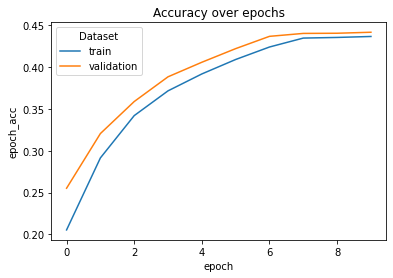

In [ ]:
sns.lineplot(data=unified_df, hue='Dataset', x='epoch', y='epoch_acc').set(title="Accuracy over epochs")

[Text(0.5, 1.0, 'Loss over epochs')]

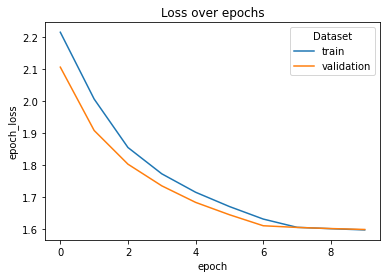

In [ ]:
sns.lineplot(data=unified_df, hue='Dataset', x='epoch', y='epoch_loss').set(title="Loss over epochs")

# 4) Tune your hyperparameters

**What's wrong?**. Looking at the loss above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy. 

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including *hidden layer size, learning rate, numer of training epochs, and adding l2 or l1 regularization to the cross entropy loss*. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

### Answer

As to my intuition here based on the error and accuracy graph, even though we did not overfit, due to our small network architecture we are close to the limit (as we can see in the last 3-4 iterations the performance of the train & validation barely changed).

Therefor I will try multiple main approches:
- Modifying the hidden layer sizes (to understand the impact here - I will try to play with multiple sizes to get the intuition on the impact - I believe adding more neurons per hidden layer will help here)


Per generated network above, I will create a baseline model, will choose the best architecture and then I will try playing with multiple hyperparameters:
- Increasing to max 20 epochs (as we did not see indications for hard overfitting I would like to see if we can get there).
- Modifying the LR / momentum

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

class NeuralNetworkV2(nn.Module):
    """
    Modification to 1st hidden layer: 100 -> 1024
    Modification to 2nd hidden layer: 20 -> 100
    """
    def __init__(self):
        super(NeuralNetworkV2, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class NeuralNetworkV3(nn.Module):
    """
    Modification to 1st hidden layer: 100 -> 512
    Modification to 2nd hidden layer: 20 -> 100
    """
    def __init__(self):
        super(NeuralNetworkV3, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits


class NeuralNetworkV4(nn.Module):
    """
    Modification to 1st hidden layer: 100 -> 1024
    Modification to 2nd hidden layer: 20 -> 512
    """
    def __init__(self):
        super(NeuralNetworkV4, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits



class NeuralNetworkV5(nn.Module):
    """
    Modification to 1st hidden layer: 100 -> 2048
    Modification to 2nd hidden layer: 20 -> 1024
    """
    def __init__(self):
        super(NeuralNetworkV5, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 2048),
            nn.ReLU(),
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
def train_model_end2end(nn_obj, criterion, num_epochs, sgd_lr, sgd_momentum, sgd_nesterov):
  model = nn_obj.to(device)
  model = model.to(device)
  optimizer_ft = optim.SGD(model.parameters(), lr=sgd_lr, momentum=sgd_momentum)

  # Decay LR by a factor of 0.1 every 7 epochs - I did not change it as recommended in the above instructions
  exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

  model, stats = train_model(model, 
                    dataloaders,
                    criterion, 
                    optimizer_ft, 
                    exp_lr_scheduler,
                    num_epochs=num_epochs)
  
  return model, stats

In [ ]:
base_model_configurations = [
 {
    "config_name": "nn_original",
    "params": {"nn_obj": NeuralNetwork(),
               "criterion": nn.CrossEntropyLoss(),
               "sgd_lr": 0.001,
               "sgd_momentum": 0.9,
               "sgd_nesterov": False,
               "num_epochs": 20} 
 },
 {
    "config_name": "nn_v2_base",
    "params": {"nn_obj": NeuralNetworkV2(),
               "criterion": nn.CrossEntropyLoss(),
               "sgd_lr": 0.001,
               "sgd_momentum": 0.9,
               "sgd_nesterov": False,
               "num_epochs": 20} 
 },
 {
    "config_name": "nn_v3_base",
    "params": {"nn_obj": NeuralNetworkV3(),
               "criterion": nn.CrossEntropyLoss(),
               "sgd_lr": 0.001,
               "sgd_momentum": 0.9,
               "sgd_nesterov": False,
               "num_epochs": 20} 
 },
 {
    "config_name": "nn_v4_base",
    "params": {"nn_obj": NeuralNetworkV4(),
               "criterion": nn.CrossEntropyLoss(),
               "sgd_lr": 0.001,
               "sgd_momentum": 0.9,
               "sgd_nesterov": False,
               "num_epochs": 20} 
 },
 {
    "config_name": "nn_v5_base",
    "params": {"nn_obj": NeuralNetworkV5(),
               "criterion": nn.CrossEntropyLoss(),
               "sgd_lr": 0.001,
               "sgd_momentum": 0.9,
               "sgd_nesterov": False,
               "num_epochs": 20} 
 }
]



base_results = []

for model_conf in base_model_configurations:
  conf_name = model_conf.get('config_name')
  params = model_conf.get('params')
  
  print(f"\n\nStarting to train model with conf name - {conf_name}")
  model, stats = train_model_end2end(**params)
  unified_stats_df = get_unified_stats_df(stats)

  base_results.append((conf_name, model, unified_stats_df))




Starting to train model with conf name - nn_original
Epoch 0/19
----------
train Loss: 2.2012 Acc: 0.2092
val Loss: 2.0705 Acc: 0.2788

Epoch 1/19
----------
train Loss: 1.9624 Acc: 0.3137
val Loss: 1.8670 Acc: 0.3457

Epoch 2/19
----------
train Loss: 1.8222 Acc: 0.3590
val Loss: 1.7673 Acc: 0.3797

Epoch 3/19
----------
train Loss: 1.7446 Acc: 0.3837
val Loss: 1.7076 Acc: 0.4035

Epoch 4/19
----------
train Loss: 1.6915 Acc: 0.4030
val Loss: 1.6625 Acc: 0.4179

Epoch 5/19
----------
train Loss: 1.6516 Acc: 0.4166
val Loss: 1.6283 Acc: 0.4271

Epoch 6/19
----------
train Loss: 1.6162 Acc: 0.4282
val Loss: 1.5983 Acc: 0.4379

Epoch 7/19
----------
train Loss: 1.5909 Acc: 0.4392
val Loss: 1.5930 Acc: 0.4405

Epoch 8/19
----------
train Loss: 1.5870 Acc: 0.4415
val Loss: 1.5899 Acc: 0.4429

Epoch 9/19
----------
train Loss: 1.5835 Acc: 0.4424
val Loss: 1.5869 Acc: 0.4436

Epoch 10/19
----------
train Loss: 1.5802 Acc: 0.4439
val Loss: 1.5840 Acc: 0.4461

Epoch 11/19
----------
train Lo

It seems that V5 network that we created above (the widest one) yielded the best results, I'll take it as our baseline model and try to optimize it using the hyperparams.
I've also increased the epochs to 30 as I want to see us getting stuck or overfitting and I did not see it yet.

In [ ]:
final_results = []
tested_lr_values = [
                    # 0.001, - Dropped after seeing results weren't too good to save time & collab resources
                    # 0.003,  - Dropped after seeing results weren't too good to save time & collab resources
                    # 0.005,  - Dropped after seeing results weren't too good to save time & collab resources
                    # 0.01,  - Dropped after seeing results weren't too good to save time & collab resources
                    0.03, 
                    0.05
]

tested_momentum_values = [
                          0.8, 
                          0.9, 
                          0.95
]


for lr in tested_lr_values:
  for momentum in tested_momentum_values:
    for nesterov in [True, False]:
      nest_str = "nesterov" if nesterov else ''
      
      conf_name = f"nn_v5_lr_{lr}_mom_{momentum}_{nest_str}"
      params = {"nn_obj": NeuralNetworkV5(),
                "criterion": nn.CrossEntropyLoss(),
                "sgd_lr": lr,
                "sgd_momentum": momentum,
                "sgd_nesterov": nesterov,
                "num_epochs": 30} 
      
      print(f"\n\nStarting to train model with conf name - {conf_name}")
      model, stats = train_model_end2end(**params)
      unified_stats_df = get_unified_stats_df(stats)

      final_results.append((conf_name, model, unified_stats_df))
      




Starting to train model with conf name - nn_v5_lr_0.03_mom_0.8_nesterov
Epoch 0/29
----------
train Loss: 1.6830 Acc: 0.4045
val Loss: 1.4933 Acc: 0.4743

Epoch 1/29
----------
train Loss: 1.4220 Acc: 0.5008
val Loss: 1.4152 Acc: 0.4983

Epoch 2/29
----------
train Loss: 1.2953 Acc: 0.5441
val Loss: 1.3597 Acc: 0.5184

Epoch 3/29
----------
train Loss: 1.1915 Acc: 0.5819
val Loss: 1.2925 Acc: 0.5466

Epoch 4/29
----------
train Loss: 1.1052 Acc: 0.6104
val Loss: 1.3042 Acc: 0.5447

Epoch 5/29
----------
train Loss: 1.0190 Acc: 0.6417
val Loss: 1.3072 Acc: 0.5432

Epoch 6/29
----------
train Loss: 0.9302 Acc: 0.6720
val Loss: 1.3282 Acc: 0.5468

Epoch 7/29
----------
train Loss: 0.6757 Acc: 0.7762
val Loss: 1.2466 Acc: 0.5769

Epoch 8/29
----------
train Loss: 0.6091 Acc: 0.8005
val Loss: 1.2622 Acc: 0.5784

Epoch 9/29
----------
train Loss: 0.5745 Acc: 0.8149
val Loss: 1.2692 Acc: 0.5818

Epoch 10/29
----------
train Loss: 0.5464 Acc: 0.8258
val Loss: 1.2824 Acc: 0.5777

Epoch 11/29


It seems that the best performance is for the network with the params:




```
{"nn_obj": NeuralNetworkV5(),
"criterion": nn.CrossEntropyLoss(),
"sgd_lr": 0.001,
"sgd_momentum": 0.9,
"sgd_nesterov": False,
"num_epochs": 30}
```



To summarize lets print the final models best iteration and the performance over epochs graph for the top 3 models:

In [ ]:
best_iters = []

for mname, _, stats_df in final_results:
  best_acc = stats_df[stats_df.Dataset == 'validation'].epoch_acc.max()
  print(f"Model: {mname} Validation best iteration acc: {best_acc}")
  best_iters.append({"model_name": mname, "best_accuracy": best_acc})

best_iters_df = pd.DataFrame(best_iters)
top_3_models = best_iters_df.sort_values('best_accuracy', ascending=False).head(3).model_name.tolist()

Model: nn_v5_lr_0.03_mom_0.8_nesterov Validation best iteration acc: 0.5865
Model: nn_v5_lr_0.03_mom_0.8_ Validation best iteration acc: 0.5859
Model: nn_v5_lr_0.03_mom_0.9_nesterov Validation best iteration acc: 0.5917
Model: nn_v5_lr_0.03_mom_0.9_ Validation best iteration acc: 0.5911000000000001
Model: nn_v5_lr_0.03_mom_0.95_nesterov Validation best iteration acc: 0.5796
Model: nn_v5_lr_0.03_mom_0.95_ Validation best iteration acc: 0.5771000000000001
Model: nn_v5_lr_0.05_mom_0.8_nesterov Validation best iteration acc: 0.5911000000000001
Model: nn_v5_lr_0.05_mom_0.8_ Validation best iteration acc: 0.5939
Model: nn_v5_lr_0.05_mom_0.9_nesterov Validation best iteration acc: 0.5815
Model: nn_v5_lr_0.05_mom_0.9_ Validation best iteration acc: 0.5839
Model: nn_v5_lr_0.05_mom_0.95_nesterov Validation best iteration acc: 0.5586
Model: nn_v5_lr_0.05_mom_0.95_ Validation best iteration acc: 0.5597


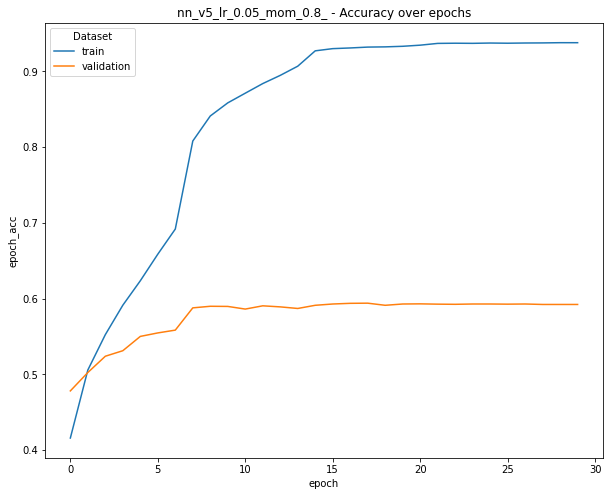

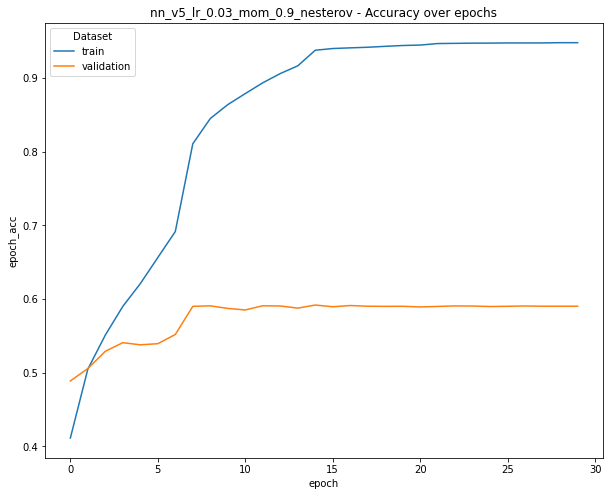

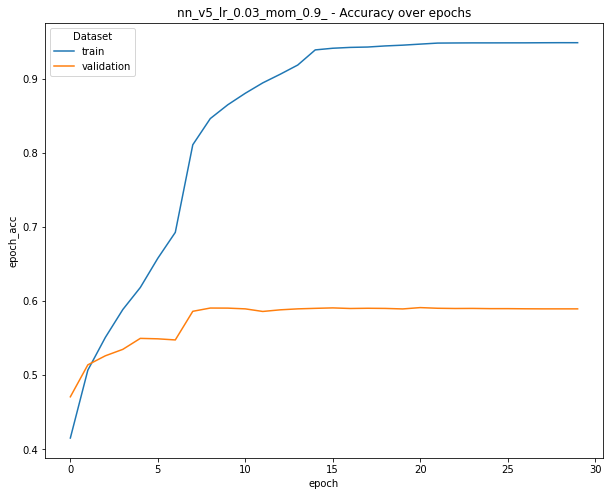

In [ ]:
for model in top_3_models:
  mname, m, mdf = [i for i in final_results if i[0] == model][0]
  plt.figure(figsize=(10,8))
  sns.lineplot(data=mdf, hue='Dataset', x='epoch', y='epoch_acc').set(title=f"{mname} - Accuracy over epochs")
  plt.show()
  print()


# Interview Question

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

*Your answer*:
The ones that can help:
* Train on a larger dataset
* Increase regularization

*Your explanation:*
1. As we have decent performance in the train set though a larger gap in the validation set, we want to generalize better, if we increase the dataset size with samples that represent reality and the validation set better we can potentially improve the results on the validation set.

2. ?

3. Increase regularization - The purpose of increased regularization is to generalize better and avoid overfitting, potentially we can use regularization here to improve the generalization and improve the validation results (and to avoid overfitting and a large gap between the train and validation).